In [52]:
%config Application.log_level='INFO'

In [53]:
import heapq
import json
from pathlib import Path
import pickle
import shutil
import numpy as np


import tqdm
from loop_alphapose_training import run_cmd, Iteration
import logging
import coloredlogs
from PIL import Image

In [54]:
from pycocotools.coco import COCO

In [55]:
logger = logging.getLogger(__name__)
coloredlogs.install(level=logging.INFO)

In [56]:
def diff_keypoints(ann1, ann2) -> float:
    if ann1 is None or ann2 is None:
        return None
    return np.linalg.norm(np.array(ann1['keypoints']) - np.array(ann2['keypoints']))


In [57]:
def bbox_to_xy(bbox) -> list[float, float, float, float]:
    bbox_x, bbox_y, bbox_w, bbox_h = bbox
    return [bbox_x, bbox_y, bbox_x + bbox_w, bbox_y + bbox_h]

In [58]:
def diff_bbox(bbox1, bbox2) -> float:
    return np.linalg.norm(np.array(bbox_to_xy(bbox1))-np.array(bbox_to_xy(bbox2)))


In [59]:
from shapely.geometry import box

def bbox_iou(bbox1, bbox2) -> float:
    """intersection over union of 2 bounding boxes"""
    b1 = box(*bbox_to_xy(bbox1))
    b2 = box(*bbox_to_xy(bbox2))
    return (b1.intersection(b2).area / b1.union(b2).area)

In [60]:
def keypoint_bbox_xy(ann):
    # fix too wide bounding boxes by calculating ourselves
    kp = np.array(ann['keypoints'])
    x = kp[0::3]
    y = kp[1::3]
    v = kp[2::3]
    min_x = min(x)
    max_x = max(x)
    min_y = min(y)
    max_y = max(y)
    return [min_x, min_y, max_x, max_y]

In [61]:
def boxes_overlap(bbox1_xy, bbox2_xy):
    x1min, y1min, x1max, y1max = bbox1_xy
    x2min, y2min, x2max, y2max = bbox2_xy
    # return x1max >= x2min and x2max >= x1min and y1max >= y2min and y2max >= y1min
    return (x1min < x2max and x2min < x1max and y1min < y2max and y2min < y1max)

In [62]:
def anns_overlap(ann1, ann2):
    return boxes_overlap(keypoint_bbox_xy(ann1), keypoint_bbox_xy(ann2))

In [63]:
from shapely.geometry import box

def match_annotations(anns1: list[dict], anns2: list[dict]) -> list[tuple]:
    # both 1 simple case:
    if len(anns1) == 1 and len(anns2) == 1:
        if not anns_overlap(anns1[0], anns2[0]):
            return [(None, None)]
        return [(anns1[0], anns2[0])]
    
    if len(anns2) == 0:
        return [(ann1, None) for ann1 in anns1]
    
    if len(anns1) == 0:
        return [(None, ann2) for ann2 in anns2]

    matches = []
    # TODO this loop is biased towards the first item in anns1, ideally
    # we first calculate the diffs between all annotations, and sort that.
    # but this is quicker and perhaps fine for our purpose
    
    # TODO this propsed solution doesn't work...
    # diffs = np.zeros((len(anns1), len(anns2)))
    # for i, ann1 in enumerate(anns1):
    #     # if len(anns2) == 0: # this can have happended in the loop
    #     #     matches.append((ann1, None))
    #     # else:
    #         diffs[i] = np.array([bbox_iou(ann1['bbox'], ann2['bbox']) for ann2 in anns2])
    #         # if ann1['image_id'] in [171729, 269815, 409216]:
    #         #     print('diff', ann1['image_id'], diffs, diffs.argmax())
    #         # idx = diffs.argmax()

    #         # if not anns_overlap(ann1, anns2[idx]):
    #         #     # closest match does not overlap. So probably none will
    #         #     matches.append((ann1, None))
    #         # else:
    #         #     match = anns2.pop(idx)
    #         #     matches.append((ann1, match))
    # anns1_not_found = anns1.copy()
    # anns2_not_found = anns2.copy()
    # orig_diffs = diffs.copy()
    # while len(diffs):
    #      idx = np.unravel_index(diffs.argmax(), diffs.shape)
    #      a1, a2 = anns1[idx[1]], anns2[idx[0]]
    #      diffs = np.delete(np.delete(diffs, idx[1], 1), idx[0], 0)
    #      matches.append((a1, a2))
    #      anns1_not_found.remove(a1)
    #      anns2_not_found.remove(a2)

    
    # matches.extend([(ann1, None) for ann1 in anns1_not_found])
    # matches.extend([(None, ann2) for ann2 in anns2_not_found])
    # return matches

    # workaround by starting with largest (thus most likely the foremost) first
    anns1.sort(key=lambda a: box(*bbox_to_xy(a['bbox'])).area, reverse=True)
    for i, ann1 in enumerate(anns1):
        if len(anns2) == 0: # this can have happended in the loop
            matches.append((ann1, None))
        else:
            diffs = np.array([bbox_iou(ann1['bbox'], ann2['bbox']) for ann2 in anns2])
            if ann1['image_id'] in [171729, 269815, 409216]:
                print('diff', ann1['image_id'], diffs, diffs.argmax())
            idx = diffs.argmax()

            if not anns_overlap(ann1, anns2[idx]):
                # closest match does not overlap. So probably none will
                matches.append((ann1, None))
            else:
                match = anns2.pop(idx)
                matches.append((ann1, match))
    
    matches.extend([(None, ann2) for ann2 in anns2])
    return matches


In [64]:
original_path = Path('data/coco/annotations/person_keypoints_train2017.json')

coco_orig = COCO(original_path)

loading annotations into memory...
Done (t=5.35s)
creating index...
index created!


In [65]:

coco_orig.anns[501841]

{'segmentation': [[154.68,
   330.84,
   148.23,
   327.62,
   150.38,
   298.62,
   150.38,
   285.73,
   125.68,
   247.06,
   123.53,
   213.76,
   117.08,
   187.98,
   132.12,
   164.35,
   136.42,
   150.38,
   135.34,
   143.94,
   129.97,
   138.57,
   127.82,
   129.97,
   128.9,
   111.71,
   129.97,
   108.49,
   137.49,
   95.6,
   138.57,
   85.93,
   145.01,
   71.97,
   153.6,
   64.45,
   185.83,
   54.78,
   200.87,
   87.01,
   201.94,
   98.82,
   200.87,
   119.23,
   218.05,
   146.09,
   230.94,
   152.53,
   238.46,
   163.27,
   248.13,
   180.46,
   252.43,
   195.5,
   259.95,
   209.46,
   262.09,
   230.94,
   262.09,
   281.43,
   262.09,
   305.06,
   264.24,
   334.06,
   258.87,
   378.1,
   258.87,
   398.51,
   264.24,
   438.26,
   274.98,
   468.33,
   257.8,
   470.48,
   228.8,
   451.15,
   228.8,
   455.44,
   229.87,
   471.56,
   205.16,
   472.63,
   199.79,
   472.63,
   183.68,
   469.41,
   181.53,
   468.33,
   172.94,
   455.44,
   168.64

In [66]:
def find_most_different_annotations(coco_orig: COCO, coco_iter: COCO, n: int = 10, only_full=False, only_singular=False) -> tuple[int, float, dict, dict]:
    matched_annotations = []
    skipped_many = 0
    for img_id, img in tqdm.tqdm(coco_orig.imgs.items()):
        # loop over images and get all annotations for each
        anns_iter = [coco_iter.anns[ann_id] for ann_id in coco_iter.getAnnIds(imgIds = img_id)]
        anns_orig = [coco_orig.anns[ann_id] for ann_id in coco_orig.getAnnIds(imgIds = img_id)]
        
        # optimise for now: filter images with just one figure
        if only_singular and (len(anns_iter) > 1 or len(anns_orig) > 1):
            skipped_many+=1
            continue
        if only_full:
            anns_iter = [ann for ann in anns_iter if all(ann['keypoints'])]
            anns_orig = [ann for ann in anns_orig if all(ann['keypoints'])]
        matched_annotations.extend([(img_id, ann1, ann2) for ann1, ann2 in match_annotations(anns_orig, anns_iter)])
        
    match_losses = []
    skipped_empty, skipped_kp = 0, 0
    for img_id, ann1, ann2 in tqdm.tqdm(matched_annotations):
        if ann1 is None or ann2 is None:
            # todo: we later want to store these somewhere else
            logger.debug(f'skipping hallucination or removal in {img_id}')
            skipped_empty+=1
            continue
        if ann1['num_keypoints'] < 3:
            logger.debug(f'skipping small number of keypoints in {img_id}')
            skipped_kp+=1
            continue
        match_losses.append((img_id, diff_keypoints(ann1, ann2), ann1, ann2))

    logger.info(f'Skipped {skipped_many} images with > 1 images')
    logger.info(f'Skipped {skipped_empty} hallucinations or removals')
    logger.info(f'Skipped {skipped_kp} annotations with small nr of keypoints')

    logger.info(f'Found {len(match_losses)} annotation pairs')

    return heapq.nlargest(n, match_losses, key=lambda ml: ml[1])


![](coco-keypoints.png)

In [67]:
np.array(coco_orig.loadCats(1)[0]['skeleton'])-1

array([[15, 13],
       [13, 11],
       [16, 14],
       [14, 12],
       [11, 12],
       [ 5, 11],
       [ 6, 12],
       [ 5,  6],
       [ 5,  7],
       [ 6,  8],
       [ 7,  9],
       [ 8, 10],
       [ 1,  2],
       [ 0,  1],
       [ 0,  2],
       [ 1,  3],
       [ 2,  4],
       [ 3,  5],
       [ 4,  6]])

In [84]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

def plotKeypointAnns(coco, anns: list, colours: list, draw_bbox = False, colour_skeleton=True):
    """
    Modifiied from pycocotools to draw annotations in predefined colours
    """
    if len(anns) == 0:
        return 0

    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for i, ann in enumerate(anns):
        c = colours[i % len(colours)]
        if 'keypoints' in ann and type(ann['keypoints']) == list:
            # turn skeleton into zero-based index
            sks = np.array(coco.loadCats(ann['category_id'])[0]['skeleton'])-1
            kp = np.array(ann['keypoints'])
            x = kp[0::3]
            y = kp[1::3]
            v = kp[2::3]
            for sk in sks:
                if np.all(v[sk]>0):
                    if colour_skeleton:
                        if sk[1] <= 4:
                            c = (0,1,0)
                        elif all(sk == [3,5]) or all(sk == [4,6]):
                            # skip, eye-shoulder
                            continue
                        elif sk[1] >= 11 and sk[0] > 12:
                            c = (1,0,0)
                        elif sk[1] in [12, 11,  6]:
                            c = (1,1,0)
                        elif sk[1] >= 7:
                            c = (0,1,1)
                        else:
                            c = (1,0,1)
                            
                    plt.plot(x[sk],y[sk], linewidth=3, color=c)
            # plt.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
            # plt.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)

        if draw_bbox:
            [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
            poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
            np_poly = np.array(poly).reshape((4,2))
            polygons.append(Polygon(np_poly))
            color.append(c)

    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)

In [69]:

from PIL import Image
import matplotlib.pyplot as plt
# annIds = coco_iter1.getAnnIds(imgIds=results[0][0], iscrowd=None)
# fn = Path('data/coco/train2017/') / coco_iter1.imgs[results[0][0]]['file_name']
# plt.imshow(Image.open(fn)); plt.axis('off')
# print(annIds)
# print(results[0][2])
# anns = coco_iter1.loadAnns(annIds)
# print(anns)
# coco_iter1.showAnns([results[0][2],results[0][3]])
# plt.show()
# plt.savefig()

def copy_annotation_matches_to_path(coco_src: COCO, path: Path, results: list[int, float, dict, dict], visualise: bool = True):
    # display(Image.open(largest_diff_files[0]))
    for img_id, diff, ann1, ann2 in results:
        source = Path('data/coco/train2017/') / coco_src.imgs[img_id]['file_name']
        fn = source.name
        dest = path / fn
        if not visualise:
            logger.info(f"Copy {source} -> {dest}")
            shutil.copy(source, dest)
        else:
            logger.info(f"Plot {source} -> {dest}")
            im = Image.open(source)
            plt.imshow(im)
            # plt.axis('off')
            plotKeypointAnns(coco_orig, [ann1, ann2], [(0.7, 0.2, 0.0), (0.0, 0.2, 0.7)], True)
            plt.show()
            plt.savefig(dest)

In [48]:
# i=10
# iteration = Iteration(i)
# if not iteration.merged_results_path('train').exists():
#     print('not existing')
#     # break
# else:
#     print(i)
#     iteration_path = iteration.merged_results_path('train')
#     coco_iterI = COCO(iteration_path)


In [49]:
# # results = find_most_different_annotations(coco_orig, coco_iter, 10)
# results = find_most_different_annotations(coco_orig, coco_iterI, 10, True, False)
# out_path = Path(f'./data/test_imgs0-{i}/')
# if not out_path.exists():
#     out_path.mkdir()
# # copy_annotation_matches_to_path(coco_orig, out_path, results)
# # break # only one for now

In [50]:
# print(coco_orig.getAnnIds(imgIds = 38449),coco_iterI.getAnnIds(imgIds = 38449))

In [72]:
# [ml[1] for ml in results]

In [71]:
coco_orig.getAnnIds(imgIds=38449)

[501841, 507179]

In [71]:
# print(results[0][0])
# print(results[0][2]['bbox'], results[0][3]['bbox'])
# print(anns_overlap(results[0][2], results[0][3]))
# print('kp box 1', keypoint_bbox_xy(results[0][2]))
# print('kp box 2', keypoint_bbox_xy(results[0][3]))
# # print(bbox_to_xy(results[0][2]['bbox']))

# results[0][2]['keypoints'], results[0][3]['keypoints']

In [70]:
# copy_annotation_matches_to_path(coco_orig, out_path, results)

In [76]:
# TODO: 
# coco_orig=None
# compare with first run, so that we always have same type of annotation (coco can be slightly different)
# coco_iter1 = COCO(Iteration(1).merged_results_path('train'))

results_path = Path('out/interesting_results.pcl')
if  results_path.exists():
    with results_path.open('rb') as fp:
        print(f"load from Pickle {results_path}")
        all_results = pickle.load(fp)
else:
    
    i = 1
    all_results=[]
    while True:
        i+=1
        iteration = Iteration(i)
        if not iteration.merged_results_path('train').exists():
            break
        print(i)
        iteration_path = iteration.merged_results_path('train')
        coco_iterI = COCO(iteration_path)
        # results = find_most_different_annotations(coco_orig, coco_iter, 10)
        results = find_most_different_annotations(coco_orig, coco_iterI, 30, True, False)
        all_results.extend(results)
        # out_path = Path(f'./data/test_imgs0-{i}/')
        # if not out_path.exists():
        #     out_path.mkdir()
        # copy_annotation_matches_to_path(coco_orig, out_path, results)
        # break # only one for now
    with results_path.open('wb') as fp:
        pickle.dump(all_results, fp)

    

load from Pickle out/interesting_results.pcl


In [77]:
interesting_img_ids = set([r[0] for r in all_results])

In [78]:
len(interesting_img_ids)

100

In [79]:
def get_coco_i(n) -> COCO:
    if n == 0:
        return coco_orig
    
    iteration = Iteration(n)
    if not iteration.merged_results_path('train').exists():
        raise RuntimeError("Iteration not found")
    
    iteration_path = iteration.merged_results_path('train')
    return COCO(iteration_path)
    

In [85]:
def draw_image_for_coco_i(i, coco, img_id, out_path):
    # display(Image.open(largest_diff_files[0]))
    anns = [coco.anns[ann] for ann in coco.getAnnIds(imgIds = img_id)]
    
    # for img_id, diff, ann1, ann2 in results:
    source = Path('data/coco/train2017/') / coco.imgs[img_id]['file_name']
    fn = source.name
    dest = out_path / fn

    dest = dest.with_name(f'{source.stem}-{i:04}{source.suffix}')
    # if not visualise:
    #     logger.info(f"Copy {source} -> {dest}")
    #     shutil.copy(source, dest)
    # else:
    logger.debug(f"Plot {source} -> {dest}")
    im = Image.open(source)
    plt.clf() # reset residue figure when in loop
    plt.imshow(im)
    plt.axis('off')
    plotKeypointAnns(coco_orig, anns, [(1,1,1)], False)
    # plt.show()
    plt.savefig(dest)

In [86]:
def draw_images_for_coco_i(i, coco, img_ids, out_path):
    for img_id in tqdm.tqdm(img_ids):
        draw_image_for_coco_i(i, coco, img_id, out_path)

In [87]:
out_path = Path(f'./out/interesting_imgs/')
if not out_path.exists():
    out_path.mkdir()


0


100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


1
loading annotations into memory...
Done (t=9.93s)
creating index...
index created!


100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


2
loading annotations into memory...
Done (t=8.61s)
creating index...
index created!


100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


3
loading annotations into memory...
Done (t=5.73s)
creating index...
index created!


100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


4
loading annotations into memory...
Done (t=7.96s)
creating index...
index created!


100%|██████████| 100/100 [00:06<00:00, 14.53it/s]


5
loading annotations into memory...
Done (t=8.06s)
creating index...
index created!


100%|██████████| 100/100 [00:08<00:00, 11.14it/s]


6
loading annotations into memory...
Done (t=8.02s)
creating index...
index created!


100%|██████████| 100/100 [00:06<00:00, 14.46it/s]


7
loading annotations into memory...
Done (t=8.31s)
creating index...
index created!


100%|██████████| 100/100 [00:06<00:00, 14.41it/s]


8
loading annotations into memory...
Done (t=8.09s)
creating index...
index created!


100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


9
loading annotations into memory...
Done (t=8.16s)
creating index...
index created!


100%|██████████| 100/100 [00:06<00:00, 14.57it/s]


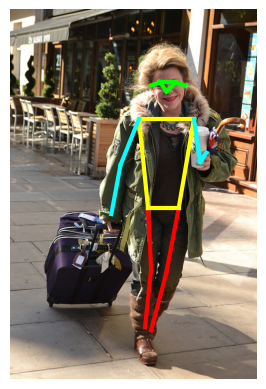

In [88]:

for i in range(10):
    print(i)
    coco = get_coco_i(i)
    draw_images_for_coco_i(i, coco, interesting_img_ids, out_path)

In [120]:

video_out_path = Path(f'./out/alphapose-feedback-videos/')
if not video_out_path.exists():
    video_out_path.mkdir()

In [ ]:

import subprocess


images = {}
for p in out_path.iterdir():
    if p.suffix != '.jpg':
        continue

    img_id, nr = p.stem.split('-')
    if img_id not in images:
        images[img_id] = []
    
    images[img_id].append(nr)

for nrs in images.values():
    nrs.sort()

for img_id, imgs in tqdm.tqdm(images.items()):
    pattern = str(out_path) + f'/{img_id}-%04d.jpg'
    out_file = str(video_out_path) + f'/{img_id}.mp4'
    # cmd=[
    #     'ffmpeg',
    #     '-y',
    #     '-r', '2',
    #     '-start_number', '0',
    #     '-i', pattern,
    #     '-c:v', 'libx264',
    #     # '-vf', 'fps=25',
    #     # '-vf', "drawtext=fontfile=Arial.ttf: text='%{frame_num}': start_number=0: x=(w-tw)/2: y=h-(2*lh): fontcolor=black: fontsize=20: box=1: boxcolor=white: boxborderw=5",
    #     # '-pix_fmt', 'yuv420p',
    #     out_file
    # ]
    ! ffmpeg -y -r 2 -start_number 0 -i {pattern} -c:v libx264 -vf fps=25 -vf "drawtext=fontfile=Arial.ttf: text='%{{frame_num}}': start_number=0: x=(w-tw)/2: y=h-(2*lh): fontcolor=black: fontsize=20: box=1: boxcolor=white: boxborderw=5" -pix_fmt yuv420p {out_file}
    # break
    # ! ls {out_path}
    # print(" ".join(cmd))
    # process = subprocess.run(cmd, timeout=30)
    # print(process.pid)
    # cmd = ['echo', str(out_path)]
    # process = subprocess.call(cmd, stdout=subprocess.PIPE, stdin=subprocess.PIPE, shell=True)
    
    # print(process.pid)
    # stdout, stderr = process.communicate()
    # print( "show something after subprocess")

    # print(" ".join(cmd))
    # subprocess.run(cmd)
    # break
    


In [119]:
video_html = ""
for img_id in images:
    video_html += f"""
    <div class='interesting_video'>
        <video src="{img_id}.mp4" autoplay loop muted></video>
        <span class='id'>{img_id}</span>
    </div>
    """

page = f"""
<html>
<title>Alphapose feedback on coco</title>
<style>
body{{font-family: sans-serif;}}
.controls{{position:sticky; top:10px;}}
.interesting_video{{
    display: inline-block;
    width: 640px;
    text-align: center;
}}
</style>
<body>
<h1>Alphapose feedback on coco</h1>
<div class='controls'>
<input type='range' min=0 max=9 id='time'>
</div>
<div id="video_grid">
{video_html}
</div>

<script>
const videos = document.getElementsByTagName('video');
const control = document.getElementById('time');
control.addEventListener('mousedown', function(){{
    for (v of videos){{ v.pause() }}
}})
control.addEventListener('mouseup', function(){{
    for (v of videos){{ v.play() }}
}})
control.addEventListener('input', function(e){{
    for (v of videos){{ v.currentTime = e.target.value/2; }}
}})
</script>
</body>
</html>
"""

out_file = video_out_path / "index.html"

out_file.write_text(page)


17195